## Minimal test of XyloSamna and XyloMonitor
- Deploying a dummy network on Xylo a2 and Xylo a3 


In [1]:
import warnings
warnings.filterwarnings("ignore")

import samna
print(f'Samna version {samna.__version__}')

import numpy as np
import matplotlib.pyplot as plt
from rockpool.devices.xylo.syns61201 import config_from_specification as a2_config_from, mapper as a2_mapper, XyloSamna as a2_XyloSamna, XyloMonitor as a2_XyloMonitor
from rockpool.devices.xylo.syns65302 import config_from_specification as a3_config_from, mapper as a3_mapper, XyloSamna as a3_XyloSamna, XyloMonitor as a3_XyloMonitor

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

Samna version 0.39.5.7+g0e6db422
from samna.xyloA3.configuration import InputInterfaceConfig


### Build a Dummy network 

In [2]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 8)),
    LIF(8),
)

### Create a simple spiking input 


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]]


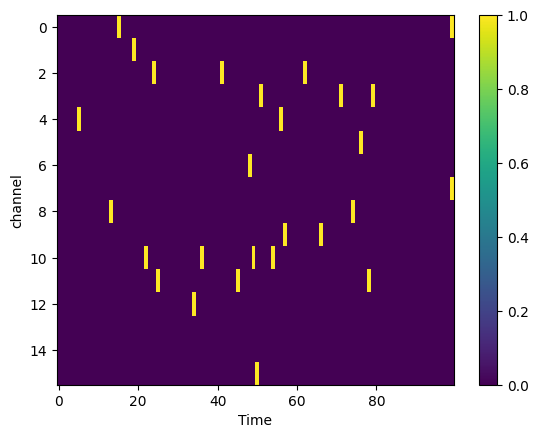

In [3]:
import matplotlib.pyplot as plt
T = 100  #number of time steps
dt = 0.01 #size of time step
Nin = 16 # number of input channels 
p = 0.02 # spiking probability
input_data = np.loadtxt('input_data.txt')
# input_data = np.random.rand(T,Nin) > (1-p)
# np.savetxt('input_data.txt', input_data)

input_data = np.array(input_data, dtype=bool)

print(input_data)
plt.figure()
plt.imshow(input_data.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

### Detecting Xylos

In [4]:
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdks, xylo_support_modules, xylo_versions = find_xylo_hdks()
print(xylo_hdks, xylo_support_modules, xylo_versions)

xa2_node = ""
xa3_node = ""

for version, xylo in zip(xylo_versions, xylo_hdks):
    if version == "syns61201":
        xa2_node = xylo
    elif version == "syns65302":
        xa3_node = xylo

print(xa2_node) if xa2_node else print("no xylo audio v2 was found")
print(xa3_node) if xa3_node else print("no xylo audio v3 was found")

The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x7e2b74937ab0>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']
no xylo audio v2 was found


### Map it to Xylo a2
- and verify the weights

In [5]:
if xa2_node:
    spec = a2_mapper(net.as_graph())
    Q_spec = spec
    Q_spec.update(channel_quantize(**Q_spec))
    a2_config, is_valid, msg = a2_config_from(**Q_spec)
    
    if not is_valid:
        print(msg)

In [6]:
if xa2_node:
    w_in = a2_config.input.weights
    w_hid = a2_config.reservoir.weights
    w_out = a2_config.readout.weights
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
    plt.subplot(132)
    plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
    plt.subplot(133)
    plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

### Testing Xylo a2
- #### with XyloSamna 

In [7]:
if xa2_node:
    dt = 0.01
    Xmod = a2_XyloSamna(xa2_node, a2_config, dt = dt)
    # print(Xmod.config)
    
    out, _, rec = Xmod.evolve(input_data, record = True)
    plt.figure(figsize=(15,5))
    plt.subplot(131), plt.imshow(out.T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
    plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto', interpolation='none');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()
    print(rec.keys())

- #### With XyloMonitor
- clapping for 3 seconds

In [8]:
if xa2_node:
    N = 3 # in seconds 
    duration = int(N * (1/dt)) 
    print(duration)
    
    a2_Monitor = a2_XyloMonitor(xa2_node, a2_config, dt = dt)
    out, _, rec = a2_Monitor.evolve(np.zeros((duration , Nin)))
    plt.figure(figsize=(15,5))
    plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()


### Testing with XyloSamna for Xylo a3

### Map it to Xylo a3
- and verifying the weights

In [9]:
if xa3_node:
    spec = a3_mapper(net.as_graph())
    Q_spec = spec
    Q_spec.update(channel_quantize(**Q_spec))
    a3_config, is_valid, msg = a3_config_from(**Q_spec)
    
    if not is_valid:
        print(msg)

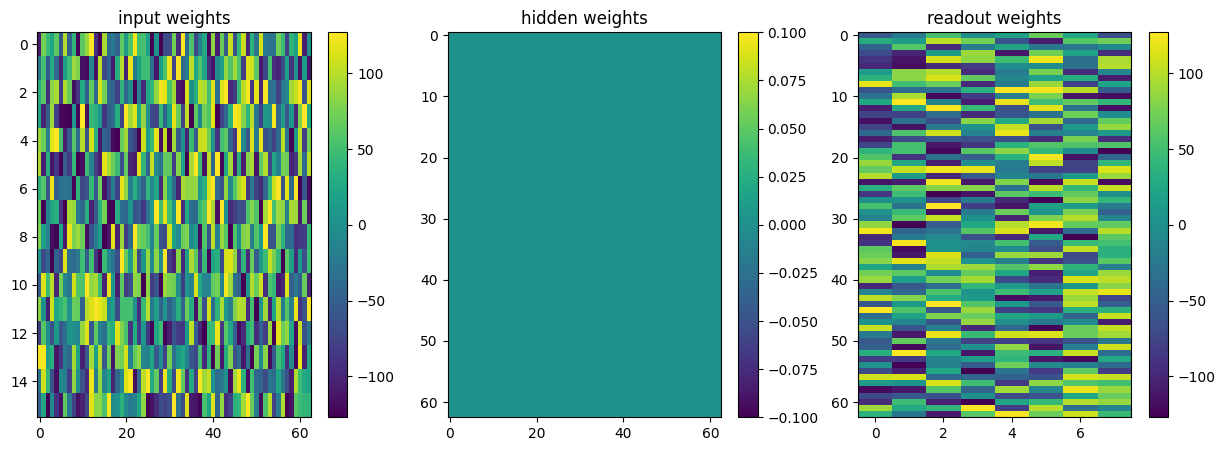

In [10]:
if xa3_node:
    w_in = a3_config.input.weights
    w_hid = a3_config.hidden.weights
    w_out = a3_config.readout.weights
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
    plt.subplot(132)
    plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
    plt.subplot(133)
    plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

In [11]:
PDM_CLK_DIR  = 1
# 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
PDM_CLK_EDGE = 0

def get_tr_wrap(ts_in_ms, main_clk_freq_in_mhz, debug=0):
    ts_duration   = ts_in_ms*1e-3; # in second
    main_clk_freq = main_clk_freq_in_mhz*1e6 # in Hz
    tr_wrap       = int(ts_duration*main_clk_freq)
    print(f"set tr_wrap to 0x{format(tr_wrap,'_X')}") if debug>=1 else None
    return tr_wrap

In [12]:
a3_config.operation_mode                                        = samna.xyloAudio3.OperationMode.AcceleratedTime
a3_config.input_source                                          = samna.xyloAudio3.InputSource.SpikeEvents
a3_config.time_resolution_wrap                                  = get_tr_wrap(ts_in_ms=1000, main_clk_freq_in_mhz=50, debug=1)
a3_config.debug.always_update_omp_stat                          = True
a3_config.digital_frontend.filter_bank.dn_enable                = False
a3_config.digital_frontend.filter_bank.use_global_iaf_threshold = False
a3_config.digital_frontend.pdm_preprocessing.clock_direction    = PDM_CLK_DIR
a3_config.digital_frontend.pdm_preprocessing.clock_edge         = PDM_CLK_EDGE
a3_config.debug.sdm_clock_ratio                                 = 24

set tr_wrap to 0x2FA_F080


In [13]:
if xa3_node:
    dt = 0.01
    Xmod = a3_XyloSamna(xa3_node, a3_config, dt = dt, power_frequency=100)    
    out, _, rec = Xmod.evolve(input_data, record = True, record_power = True)

1


In [14]:
print(len(rec['io_power']))
print(len(rec['analog_power']))
print(len(rec['digital_power']))

io_power = np.mean(rec['io_power'])
analog = np.mean(rec['analog_power'])
digital = np.mean(rec['digital_power'])


print(f'XyloAudio 3\nAll IO:\t\t{io_power * 1000:.1f} mW\nAFE core:\t{analog * 1000:.1f} mW\nSNN core logic:\t{digital*1000:.1f} mW')

72
72
72
XyloAudio 3
All IO:		0.3 mW
AFE core:	0.0 mW
SNN core logic:	3.8 mW


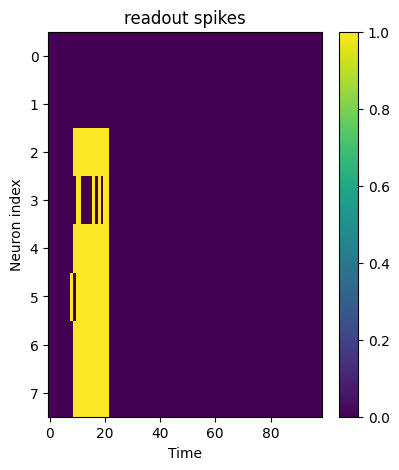

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
